<span style='color:gray'> <span style="font-size:25px;"> **Development of "Machine Learning Models"  (Workflow)**
    
In this Notebook, the machine learning model will be created and then the data from well-logs DLIS file [after preprocessing, sorting and finalizing the data] is loaded as input for Machine Learning model (ML); 
* Random Forest Regressor
* Gradient Boosting Regressor
    
    
For the prediction of petrophysical properties, such as porosity, permeability and water saturation, these two Regressor models **Random Forest Regressor** and **Gradient Boosting Regressor** are suitable.

They are Ensemble Based Tree Methods; they are based on the generation of Decision Trees.

We use Regression Models since we want to predict a continuous variable.

**Advantages** of the 2 regression models, since they are based on Decision Trees:

* They do not need the normalization or scaling of the original dataset;
* They are not sensitive to outliers, thus, outliers detection and removal are not required.

**==================================================================================================================**
    
In well-log machine learning models, the choice between regression and classification (Supervised ML) depends on the nature of the problem you are trying to solve and the type of data you have. Let's break down the reasons why regression is often preferred over classification in this context:

**Continuous Output**: Well-log data often involves continuous measurements such as porosity, permeability, resistivity, and other geological properties. Regression is well-suited for predicting and modeling continuous numerical values. Classification, on the other hand, is typically used when the output is categorical or discrete, like classifying lithology or rock types.

**Data Distribution**: Well-log data tends to have a wide range of continuous values. Using classification would require discretizing this data into bins or classes, which can lead to loss of information and potentially introduce biases. Regression models can capture the nuances and variations present in the continuous data more effectively.

**Evaluation Metrics**: Regression models are evaluated using metrics such as mean squared error (MSE), root mean squared error (RMSE), or mean absolute error (MAE). These metrics are well-suited for measuring the accuracy of predictions involving continuous values. Classification models, on the other hand, use metrics like accuracy, precision, recall, and F1-score, which are designed for categorical predictions.

**Feature Importance**: Well-log data analysis often involves understanding the relationships between different geological features and the target property. Regression models can provide insights into the quantitative impact of each feature on the predicted values, aiding in geological interpretation.


<span style='color:gray'> <span style="font-size:20px;"> 
**Importing Libraries, Regressors, and Required Dependencies**

In [4]:
%pip install --quiet --upgrade scikit-learn==1.2.2
%pip install --quiet qbstyles


# Importing the dependencies
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from qbstyles import mpl_style
mpl_style(dark=False)  # Set light matplotlib style

import matplotlib.patches as mpatches  # To create a legend with a color box
import pickle

from sklearn import preprocessing


# Importing the models 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
                                         
from sklearn.model_selection import RandomizedSearchCV

# train_test_split is a function 
# cross_val_score and KFold are functions

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold 

# Regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error, mean_absolute_error

# The package "Matplotlib Inline Back-end" provides support for Matplotlib to display figures directly inline
# "svg" stands for "scalable vector graphic". The plot can be scaled without compromising its quality
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

<span style='color:red'> <span style="font-size:20px;"> **3-BRSA-944A-RJS**:</span> </span>

<span style='color:blue'> <span style="font-size:15px;"> **Well-log data**:</span> </span>

In [5]:
#file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_944_ML.csv'
file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_944_ML_COM.csv'

df_944_ML =  pd.read_csv(file_path)
df_944_ML.rename(columns={'CMFF': 'NMRFF', 'CMRP_3MS': 'NMREFF', 'TCMR': 'NMRTOT'}, inplace=True)
df_944_ML.drop(columns = ['AT10', 'AT30'], inplace=True) # Replace with the actual column names you want to remove
df_944_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_944_ML

<span style='color:blue'> <span style="font-size:15px;"> **Trajectory data**:</span> </span>

In [6]:
pd.reset_option('display.max_rows')

In [7]:
def remove_lines_from_file(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Remove specified lines
    lines = [line for i, line in enumerate(lines, 1) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(lines)

# Specify the input file, output file, and line numbers to remove
input_file = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados Direcionais/3-brsa-944a-rjs_direcionais.txt'
output_file = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados Direcionais/output.txt'
lines_to_remove = list(range(0, 25))     # remove to line 

# Call the function to remove the specified lines
remove_lines_from_file(input_file, output_file, lines_to_remove)

#======================== loading new file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados Direcionais/output.txt'

# Read the file into a Pandas DataFrame using space as the delimiter
df = pd.read_csv(file_path, delim_whitespace=True)   
df = df.iloc[1:-1]    # Remove the and first last row

#======================== loading new file
df = df[['PROFUNDIDADE', 'PROFUNDIDADE.1', 'INCLINACAO', 'AZIMUTE']]
df = df.rename(columns={'PROFUNDIDADE': 'MD'})
df = df.rename(columns={'PROFUNDIDADE.1': 'TVD'})
df = df.rename(columns={'INCLINACAO': 'INC'})
df = df.rename(columns={'AZIMUTE': 'AZI'})
df.reset_index(drop=True, inplace=True)                       # Reset the index
#df

<span style='color:blue'> <span style="font-size:15px;"> **Petrophysics data**:</span> </span>

In [8]:
# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-944A-RJS/Dados de Rochas e Fluidos/PETROGRAFIA_BASICA/3BRSA944ARJSPetrofisica_2.xls'
df_Ptroph_944 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_944 = df_Ptroph_944[["Profundidade", "Permeab. Long. (mD)", "Porosidade %"]].sort_values("Profundidade", ascending=True).dropna()

#df_Ptroph = df_Ptroph.iloc[102:164]  # Extract rows A to B (inclusive)
df_Ptroph_944 = df_Ptroph_944.reset_index(drop=True)  # Reset the index after sorting

#====

# Convert the columns to string type
df_Ptroph_944['Permeab. Long. (mD)'] = df_Ptroph_944['Permeab. Long. (mD)'].astype('str')
df_Ptroph_944['Porosidade %'] = df_Ptroph_944['Porosidade %'].astype('str')
df_Ptroph_944['Profundidade'] = df_Ptroph_944['Profundidade'].astype('str')

# Use the `.str.replace()` method to replace the commas with periods
df_Ptroph_944['Permeab. Long. (mD)'] = df_Ptroph_944['Permeab. Long. (mD)'].str.replace(',', '.')
df_Ptroph_944['Porosidade %'] = df_Ptroph_944['Porosidade %'].str.replace(',', '.')
df_Ptroph_944['Profundidade'] = df_Ptroph_944['Profundidade'].str.replace(',', '.')

# Convert the columns back to numeric type
df_Ptroph_944['Permeab. Long. (mD)'] = pd.to_numeric(df_Ptroph_944['Permeab. Long. (mD)'])
df_Ptroph_944['Porosidade %'] = pd.to_numeric(df_Ptroph_944['Porosidade %'])
df_Ptroph_944['Profundidade'] = pd.to_numeric(df_Ptroph_944['Profundidade'])

#pd.reset_option('display.max_rows')
pd.set_option('display.max_rows', None)


df_Ptroph_944 = df_Ptroph_944.rename(columns={'Profundidade': 'MD', 'Permeab. Long. (mD)': 'k', 'Porosidade %': 'phi'})


# Continue with your code
DEPTH_lab = df_Ptroph_944["MD"]
K_lab = df_Ptroph_944["k"]
PHI_lab = df_Ptroph_944["phi"]

#df_Ptroph_944

In [9]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_Ptroph_944.csv'

df_Ptroph_944.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_Ptroph_944.csv


<span style='color:blue'> <span style="font-size:15px;"> **Build a well-log dataframe based on Petrophysical dataframe**:</span> </span>

In [10]:
depth_range = (df_Ptroph_944['MD'].min(), df_Ptroph_944['MD'].max())

# Convert to strings, replace commas with dots, and convert to floats
initial_depth = float(str(depth_range[0]).replace(',', '.'))
final_depth = float(str(depth_range[1]).replace(',', '.'))

print("Initial Depth:", initial_depth)
print("Final Depth:", final_depth)


Initial Depth: 5715.15
Final Depth: 5795.75


Limit the well-log data [defining the upper and lower limit] for well-log data based on petrophyscial data

In [11]:
# Filter the DataFrame to include rows with 'MD' within the depth range
df_944_ML = df_944_ML[(df_944_ML['DEPTH'] >= depth_range[0]) & (df_944_ML['DEPTH'] <= depth_range[1])]
#df_944_ML

we filtered the well-log data corresponding to the DEPTH in Petrophysical data, 

In [12]:
# Convert the 'MD' columns to NumPy arrays for faster calculations
depth_values = df_Ptroph_944['MD'].values
depth_944_values = df_944_ML['DEPTH'].values

selected_rows = []   # Create an empty list to store the selected rows

for depth in depth_values:
    absolute_diff = np.abs(depth_944_values - depth)              # Calculate the absolute differences between 'MD' values
                                                                  # in df_Ptroph_944 and 'DEPTH' values in df_944_ML

    
    nearest_depth_index = np.argmin(absolute_diff)                # Find the index of the minimum absolute difference
    
    selected_rows.append(df_944_ML.iloc[nearest_depth_index])     # Append the nearest row to the list

df_944_ML = pd.DataFrame(selected_rows)                              # Create a DataFrame from the selected rows
df_944_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_944_ML

In [13]:
# Sort both dataframes by 'MD' and 'DEPTH' respectively
df_944_ML = df_944_ML.sort_values(by='DEPTH')
df_Ptroph_944 = df_Ptroph_944.sort_values(by='MD')

# Merge the dataframes using 'merge_asof' to find the nearest depth in df_944_ML for each depth in df_Ptroph
df_944_PM = pd.merge_asof(df_Ptroph_944, df_944_ML, left_on='MD', right_on='DEPTH', direction='nearest')

df_944_PM = df_944_PM.drop('MD', axis=1)

# The 'result' dataframe now contains the rows from df_944_ML corresponding to depths in df_Ptroph
#df_944_PM

In [14]:
df_944_PM = df_944_PM.drop_duplicates(subset=['DEPTH', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT'])
df_944_PM.reset_index(drop=True, inplace=True)                       # Reset the index

df_944_PM = df_944_PM[['DEPTH'] + [col for col in df_944_PM if col != 'DEPTH']]
#df_944_PM

In [15]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_944_PM.csv'

df_944_PM.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_944_PM.csv


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

<span style='color:red'> <span style="font-size:20px;"> **3-BRSA-1215-RJS**:</span> </span>

<span style='color:blue'> <span style="font-size:15px;"> **Well-log data**:</span> </span>

In [16]:
file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_1215_ML.csv'
df_1215_ML =  pd.read_csv(file_path)
df_1215_ML.rename(columns={'CMFF': 'NMRFF', 'CMRP_3MS': 'NMREFF', 'TCMR': 'NMRTOT'}, inplace=True)
df_1215_ML.drop(columns = ['AT10', 'AT30'], inplace=True) # Replace with the actual column names you want to remove
df_1215_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_1215_ML

<span style='color:blue'> <span style="font-size:15px;"> **Trajectory data**:</span> </span>

In [17]:
def remove_lines_from_file(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Remove specified lines
    lines = [line for i, line in enumerate(lines, 1) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(lines)

# Specify the input file, output file, and line numbers to remove
input_file = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados Direcionais/3-brsa-1215-rjs_direcionais.txt'
output_file = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados Direcionais/output.txt'
lines_to_remove = list(range(0, 23))     # remove to line 

# Call the function to remove the specified lines
remove_lines_from_file(input_file, output_file, lines_to_remove)

#======================== loading new file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados Direcionais/output.txt'

# Read the file into a Pandas DataFrame using space as the delimiter
df = pd.read_csv(file_path, delim_whitespace=True)   
df = df.iloc[1:-1]    # Remove the and first last row
df
#======================== loading new file
df = df[['PROFUNDIDADE', 'PROFUNDIDADE.1', 'INCLINACAO', 'AZIMUTE']]
df = df.rename(columns={'PROFUNDIDADE': 'MD'})
df = df.rename(columns={'PROFUNDIDADE.1': 'TVD'})
df = df.rename(columns={'INCLINACAO': 'INC'})
df = df.rename(columns={'AZIMUTE': 'AZI'})
#df

<span style='color:blue'> <span style="font-size:15px;"> **Petrophysics data**:</span> </span>

In [18]:
# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/3-BRSA-1215-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/3BRSA1215RJS_Petrofisica_Basica.xlsx'
df_Ptroph_1215 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_1215 = df_Ptroph_1215[["Profundidade", "Permeabilidade Long. (mD)", "Porosidade%"]].sort_values("Profundidade", ascending=True).dropna()

#df_Ptroph = df_Ptroph.iloc[102:164]  # Extract rows A to B (inclusive)
df_Ptroph_1215 = df_Ptroph_1215.reset_index(drop=True)  # Reset the index after sorting

# Convert the columns to string type
df_Ptroph_1215['Permeabilidade Long. (mD)'] = df_Ptroph_1215['Permeabilidade Long. (mD)'].astype('str')
df_Ptroph_1215['Porosidade%'] = df_Ptroph_1215['Porosidade%'].astype('str')
df_Ptroph_1215['Profundidade'] = df_Ptroph_1215['Profundidade'].astype('str')

# Use the `.str.replace()` method to replace the commas with periods
df_Ptroph_1215['Permeabilidade Long. (mD)'] = df_Ptroph_1215['Permeabilidade Long. (mD)'].str.replace(',', '.')
df_Ptroph_1215['Porosidade%'] = df_Ptroph_1215['Porosidade%'].str.replace(',', '.')
df_Ptroph_1215['Profundidade'] = df_Ptroph_1215['Profundidade'].str.replace(',', '.')

# Convert the columns back to numeric type
df_Ptroph_1215['Permeabilidade Long. (mD)'] = pd.to_numeric(df_Ptroph_1215['Permeabilidade Long. (mD)'])
df_Ptroph_1215['Porosidade%'] = pd.to_numeric(df_Ptroph_1215['Porosidade%'])
df_Ptroph_1215['Profundidade'] = pd.to_numeric(df_Ptroph_1215['Profundidade'])



df_Ptroph_1215 = df_Ptroph_1215.rename(columns={'Profundidade': 'MD', 'Permeabilidade Long. (mD)': 'k', 'Porosidade%': 'phi'})
df_Ptroph_1215.reset_index(drop=True, inplace=True)                       # Reset the index
#df_Ptroph_1215

<span style='color:blue'> <span style="font-size:15px;"> **Build a well-log dataframe based on Petrophysical dataframe**:</span> </span>

In [19]:
depth_range = (df_Ptroph_1215['MD'].min(), df_Ptroph_1215['MD'].max())

# Replace commas with dots (periods) and convert to floats
initial_depth = float(str(depth_range[0]).replace(',', '.'))
final_depth = float(str(depth_range[1]).replace(',', '.'))

print("Initial Depth:", initial_depth)
print("Final Depth:", final_depth)

Initial Depth: 5413.4
Final Depth: 5677.3


In [20]:
# Filter the DataFrame to include rows with 'MD' within the depth range
df_1215_ML = df_1215_ML[(df_1215_ML['DEPTH'] >= depth_range[0]) & (df_1215_ML['DEPTH'] <= depth_range[1])]
#df_1215_ML

In [21]:
"""# Filter the DataFrame to include rows with 'MD' within the depth range
df_1215_ML = df_1215_ML[(df_1215_ML['DEPTH'] >= float(depth_range[0])) & (df_1215_ML['DEPTH'] <= float(depth_range[1]))]
df_1215_ML"""

"# Filter the DataFrame to include rows with 'MD' within the depth range\ndf_1215_ML = df_1215_ML[(df_1215_ML['DEPTH'] >= float(depth_range[0])) & (df_1215_ML['DEPTH'] <= float(depth_range[1]))]\ndf_1215_ML"

In [22]:
# Convert the 'MD' columns to NumPy arrays for faster calculations
depth_values = df_Ptroph_1215['MD'].values
depth_1215_values = df_1215_ML['DEPTH'].values

selected_rows = []   # Create an empty list to store the selected rows

for depth in depth_values:
    absolute_diff = np.abs(depth_1215_values - depth)              # Calculate the absolute differences between 'MD' values
                                                                  # in df_Ptroph_944 and 'DEPTH' values in df_944_ML

    
    nearest_depth_index = np.argmin(absolute_diff)                # Find the index of the minimum absolute difference
    
    selected_rows.append(df_1215_ML.iloc[nearest_depth_index])     # Append the nearest row to the list

df_1215_ML = pd.DataFrame(selected_rows)                              # Create a DataFrame from the selected rows
df_1215_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_1215_ML

In [23]:
# Sort both dataframes by 'MD' and 'DEPTH' respectively
df_1215_ML = df_1215_ML.sort_values(by='DEPTH')
df_Ptroph_1215 = df_Ptroph_1215.sort_values(by='MD')

# Merge the dataframes using 'merge_asof' to find the nearest depth in df_944_ML for each depth in df_Ptroph
df_1215_PM = pd.merge_asof(df_Ptroph_1215, df_1215_ML, left_on='MD', right_on='DEPTH', direction='nearest')

df_1215_PM = df_1215_PM.drop('MD', axis=1)

# The 'result' dataframe now contains the rows from df_944_ML corresponding to depths in df_Ptroph
df_1215_PM.reset_index(drop=True, inplace=True)                       # Reset the index
#df_1215_PM

In [24]:
df_1215_PM = df_1215_PM.drop_duplicates(subset=['DEPTH', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT'])
df_1215_PM.reset_index(drop=True, inplace=True)                       # Reset the index

df_1215_PM = df_1215_PM[['DEPTH'] + [col for col in df_1215_PM if col != 'DEPTH']]
#df_1215_PM

In [25]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_1215_PM.csv'

df_1215_PM.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_1215_PM.csv


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

<span style='color:Red'> <span style="font-size:20px;"> 
**1-BRSA-1116-RJS**

<span style='color:blue'> <span style="font-size:15px;"> **Well-log data**:</span> </span>

In [26]:
file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_1116_ML.csv'
df_1116_ML =  pd.read_csv(file_path)
df_1116_ML.rename(columns={'CMFF': 'NMRFF', 'CMRP_3MS': 'NMREFF', 'TCMR': 'NMRTOT'}, inplace=True)
df_1116_ML.drop(columns = ['AT10', 'AT30'], inplace=True) # Replace with the actual column names you want to remove
df_1116_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_1116_ML

<span style='color:blue'> <span style="font-size:15px;"> **Trajectory data**:</span> </span>

In [27]:
def remove_lines_from_file(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Remove specified lines
    lines = [line for i, line in enumerate(lines, 1) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(lines)

# Specify the input file, output file, and line numbers to remove
input_file = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados Direcionais/1-brsa-1116-rjs_direcionais.txt'
output_file = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados Direcionais/output.txt'
lines_to_remove = list(range(0, 25))     # remove to line 

# Call the function to remove the specified lines
remove_lines_from_file(input_file, output_file, lines_to_remove)

#======================== loading new file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados Direcionais/output.txt'

# Read the file into a Pandas DataFrame using space as the delimiter
df = pd.read_csv(file_path, delim_whitespace=True)   
df = df.iloc[1:-1]    # Remove the and first last row

#======================== loading new file
df = df[['PROFUNDIDADE', 'PROFUNDIDADE.1', 'INCLINACAO', 'AZIMUTE']]
df = df.rename(columns={'PROFUNDIDADE': 'MD'})
df = df.rename(columns={'PROFUNDIDADE.1': 'TVD'})
df = df.rename(columns={'INCLINACAO': 'INC'})
df = df.rename(columns={'AZIMUTE': 'AZI'})
df.reset_index(drop=True, inplace=True)                       # Reset the index
#df

<span style='color:blue'> <span style="font-size:15px;"> **Petrophysics data**:</span> </span>

In [28]:
# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/1-BRSA-1116-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/1BRSA1116RJS_Petrofisicabasica_2.xls'
df_Ptroph_1116 = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_1116 = df_Ptroph_1116[["Profundidade", "Permeab. Long. (mD)", "Porosidade %"]].sort_values("Profundidade", ascending=True).dropna()

#df_Ptroph = df_Ptroph.iloc[102:164]  # Extract rows A to B (inclusive)
df_Ptroph_1116 = df_Ptroph_1116.reset_index(drop=True)  # Reset the index after sorting

# 1) Filter out rows with '-' in the "Porosidade%" column
# 2) Now, you can replace ',' with '.' and convert the "Porosidade%" column to float

# Convert the columns to string type
df_Ptroph_1116['Permeab. Long. (mD)'] = df_Ptroph_1116['Permeab. Long. (mD)'].astype('str')
df_Ptroph_1116['Porosidade %'] = df_Ptroph_1116['Porosidade %'].astype('str')
df_Ptroph_1116['Profundidade'] = df_Ptroph_1116['Profundidade'].astype('str')

# Use the `.str.replace()` method to replace the commas with periods
df_Ptroph_1116['Permeab. Long. (mD)'] = df_Ptroph_1116['Permeab. Long. (mD)'].str.replace(',', '.')
df_Ptroph_1116['Porosidade %'] = df_Ptroph_1116['Porosidade %'].str.replace(',', '.')
df_Ptroph_1116['Profundidade'] = df_Ptroph_1116['Profundidade'].str.replace(',', '.')

# Convert the columns back to numeric type
df_Ptroph_1116['Permeab. Long. (mD)'] = pd.to_numeric(df_Ptroph_1116['Permeab. Long. (mD)'])
df_Ptroph_1116['Porosidade %'] = pd.to_numeric(df_Ptroph_1116['Porosidade %'])
df_Ptroph_1116['Profundidade'] = pd.to_numeric(df_Ptroph_1116['Profundidade'])


"""
# Continue with your code
DEPTH_lab = df_Ptroph_944["Profundidade"]
K_lab = df_Ptroph_944["Permeab. Long. (mD)"]
PHI_lab = df_Ptroph_944["Porosidade %"]
"""

df_Ptroph_1116 = df_Ptroph_1116.rename(columns={'Profundidade': 'MD', 'Permeab. Long. (mD)': 'k', 'Porosidade %': 'phi'})
#df_Ptroph_1116

<span style='color:blue'> <span style="font-size:15px;"> **Build a well-log dataframe based on Petrophysical dataframe**:</span> </span>

In [29]:
depth_range = (df_Ptroph_1116['MD'].min(), df_Ptroph_1116['MD'].max())

# Convert to strings, replace commas with dots, and convert to floats
initial_depth = float(str(depth_range[0]).replace(',', '.'))
final_depth = float(str(depth_range[1]).replace(',', '.'))

print("Initial Depth:", initial_depth)
print("Final Depth:", final_depth)

Initial Depth: 5364.15
Final Depth: 5408.15


Limit the well-log data [defining the upper and lower limit] for well-log data based on petrophyscial data

In [30]:
# Filter the DataFrame to include rows with 'MD' within the depth range
df_1116_ML = df_1116_ML[(df_1116_ML['DEPTH'] >= depth_range[0]) & (df_1116_ML['DEPTH'] <= depth_range[1])]
#df_1116_ML

In [31]:
# Convert the 'MD' columns to NumPy arrays for faster calculations
depth_values = df_Ptroph_1116['MD'].values
depth_1116_values = df_1116_ML['DEPTH'].values

selected_rows = []   # Create an empty list to store the selected rows

for depth in depth_values:
    absolute_diff = np.abs(depth_1116_values - depth)              # Calculate the absolute differences between 'MD' values
                                                                  # in df_Ptroph_944 and 'DEPTH' values in df_944_ML

    
    nearest_depth_index = np.argmin(absolute_diff)                # Find the index of the minimum absolute difference
    
    selected_rows.append(df_1116_ML.iloc[nearest_depth_index])     # Append the nearest row to the list

df_1116_ML = pd.DataFrame(selected_rows)                              # Create a DataFrame from the selected rows
df_1116_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_1116_ML

In [32]:
# Sort both dataframes by 'MD' and 'DEPTH' respectively
df_1116_ML = df_1116_ML.sort_values(by='DEPTH')
df_Ptroph_1116 = df_Ptroph_1116.sort_values(by='MD')

# Merge the dataframes using 'merge_asof' to find the nearest depth in df_944_ML for each depth in df_Ptroph
df_1116_PM = pd.merge_asof(df_Ptroph_1116, df_1116_ML, left_on='MD', right_on='DEPTH', direction='nearest')

df_1116_PM = df_1116_PM.drop('MD', axis=1)

# The 'result' dataframe now contains the rows from df_944_ML corresponding to depths in df_Ptroph
df_1116_PM.reset_index(drop=True, inplace=True)                       # Reset the index
#df_1116_PM

In [33]:
df_1116_PM = df_1116_PM.drop_duplicates(subset=['DEPTH', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT'])
df_1116_PM.reset_index(drop=True, inplace=True)                       # Reset the index

df_1116_PM = df_1116_PM[['DEPTH'] + [col for col in df_1116_PM if col != 'DEPTH']]
#df_1116_PM

In [34]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_1116_PM.csv'

df_1116_PM.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_1116_PM.csv


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

<span style='color:Red'> <span style="font-size:20px;"> 
**9-lTP-1-RJS**

<span style='color:blue'> <span style="font-size:15px;"> **Well-log data**:</span> </span>

In [35]:
file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_9_ITP_ML.csv'
df_9_ITP_ML =  pd.read_csv(file_path)
df_9_ITP_ML.rename(columns={'CMFF': 'NMRFF', 'CMRP_3MS': 'NMREFF', 'TCMR': 'NMRTOT'}, inplace=True)
df_9_ITP_ML.drop(columns = ['AT10', 'AT30'], inplace=True) # Replace with the actual column names you want to remove
df_9_ITP_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_9_ITP_ML

<span style='color:blue'> <span style="font-size:15px;"> **Trajectory data**:</span> </span>

In [36]:
def remove_lines_from_file(input_file, output_file, lines_to_remove):
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Remove specified lines
    lines = [line for i, line in enumerate(lines, 1) if i not in lines_to_remove]

    with open(output_file, 'w') as file:
        file.writelines(lines)

# Specify the input file, output file, and line numbers to remove
input_file = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados Direcionais/9-itp-1-rjs_direcional.txt'
output_file = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados Direcionais/output.txt'
lines_to_remove = list(range(0, 25))     # remove to line 

# Call the function to remove the specified lines
remove_lines_from_file(input_file, output_file, lines_to_remove)
#======================== loading new file

file_path = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados Direcionais/output.txt'

# Read the file into a Pandas DataFrame using space as the delimiter
df = pd.read_csv(file_path, delim_whitespace=True)   
df = df.iloc[1:-1]    # Remove the and first last row

#======================== loading new file
df = df[['PROFUNDIDADE', 'PROFUNDIDADE.1', 'INCLINACAO', 'AZIMUTE']]
df = df.rename(columns={'PROFUNDIDADE': 'MD'})
df = df.rename(columns={'PROFUNDIDADE.1': 'TVD'})
df = df.rename(columns={'INCLINACAO': 'INC'})
df = df.rename(columns={'AZIMUTE': 'AZI'})
df.reset_index(drop=True, inplace=True)                       # Reset the index
#df

<span style='color:blue'> <span style="font-size:15px;"> **Petrophysics data**:</span> </span>

In [37]:
# Replace 'your_file.xlsx' with the path to your Excel file
file_path = '/Users/amirhosseinakhondzadeh/@ DATA/9-lTP-1-RJS/Dados de Rochas e Fluidos/PETROFISICABASICA/9ITP 0001  RJS-Petrofisica Basica.xls'
df_Ptroph_9_ITP = pd.read_excel(file_path)

# Extract the desired columns and sort by "Profundidade" while dropping NaN values
df_Ptroph_9_ITP = df_Ptroph_9_ITP[["Profundidade", "Permeabilidade Long. (mD)", "Porosidade%"]].sort_values("Profundidade", ascending=True).dropna()

df_Ptroph_9_ITP = df_Ptroph_9_ITP.iloc[0:97]  # Extract rows A to B (inclusive)
df_Ptroph_9_ITP = df_Ptroph_9_ITP.reset_index(drop=True)  # Reset the index after sorting

df_Ptroph_9_ITP = df_Ptroph_9_ITP[df_Ptroph_9_ITP["Porosidade%"] != '-'] # 1

# Convert the columns to string type
df_Ptroph_9_ITP['Permeabilidade Long. (mD)'] = df_Ptroph_9_ITP['Permeabilidade Long. (mD)'].astype('str')
df_Ptroph_9_ITP['Porosidade%'] = df_Ptroph_9_ITP['Porosidade%'].astype('str')
df_Ptroph_9_ITP['Profundidade'] = df_Ptroph_9_ITP['Profundidade'].astype('str')

# Use the `.str.replace()` method to replace the commas with periods
df_Ptroph_9_ITP['Permeabilidade Long. (mD)'] = df_Ptroph_9_ITP['Permeabilidade Long. (mD)'].str.replace(',', '.')
df_Ptroph_9_ITP['Porosidade%'] = df_Ptroph_9_ITP['Porosidade%'].str.replace(',', '.')
df_Ptroph_9_ITP['Profundidade'] = df_Ptroph_9_ITP['Profundidade'].str.replace(',', '.')

# Convert the columns back to numeric type
df_Ptroph_9_ITP['Permeabilidade Long. (mD)'] = pd.to_numeric(df_Ptroph_9_ITP['Permeabilidade Long. (mD)'])
df_Ptroph_9_ITP['Porosidade%'] = pd.to_numeric(df_Ptroph_9_ITP['Porosidade%'])
df_Ptroph_9_ITP['Profundidade'] = pd.to_numeric(df_Ptroph_9_ITP['Profundidade'])

df_Ptroph_9_ITP = df_Ptroph_9_ITP.rename(columns={'Profundidade': 'MD', 'Permeabilidade Long. (mD)': 'k', 'Porosidade%': 'phi'})
#df_Ptroph_9_ITP

<span style='color:blue'> <span style="font-size:15px;"> **Build a well-log dataframe based on Petrophysical dataframe**:</span> </span>

In [38]:
depth_range = (df_Ptroph_9_ITP['MD'].min(), df_Ptroph_9_ITP['MD'].max())

# Convert to strings, replace commas with dots, and convert to floats
initial_depth = float(str(depth_range[0]).replace(',', '.'))
final_depth = float(str(depth_range[1]).replace(',', '.'))

print("Initial Depth:", initial_depth)
print("Final Depth:", final_depth)

Initial Depth: 5226.15
Final Depth: 5267.65


Limit the well-log data [defining the upper and lower limit] for well-log data based on petrophyscial data

In [39]:
# Filter the DataFrame to include rows with 'MD' within the depth range
df_9_ITP_ML = df_9_ITP_ML[(df_9_ITP_ML['DEPTH'] >= depth_range[0]) & (df_9_ITP_ML['DEPTH'] <= depth_range[1])]
#df_9_ITP_ML

In [40]:
# Convert the 'MD' columns to NumPy arrays for faster calculations
depth_values = df_Ptroph_9_ITP['MD'].values
depth_9_ITP_values = df_9_ITP_ML['DEPTH'].values

selected_rows = []   # Create an empty list to store the selected rows

for depth in depth_values:
    absolute_diff = np.abs(depth_9_ITP_values - depth)              # Calculate the absolute differences between 'MD' values
                                                                  # in df_Ptroph_944 and 'DEPTH' values in df_944_ML

    
    nearest_depth_index = np.argmin(absolute_diff)                # Find the index of the minimum absolute difference
    
    selected_rows.append(df_9_ITP_ML.iloc[nearest_depth_index])     # Append the nearest row to the list

df_9_ITP_ML = pd.DataFrame(selected_rows)                              # Create a DataFrame from the selected rows
df_9_ITP_ML.reset_index(drop=True, inplace=True)                       # Reset the index
#df_9_ITP_ML

In [41]:
# Sort both dataframes by 'MD' and 'DEPTH' respectively
df_9_ITP_ML = df_9_ITP_ML.sort_values(by='DEPTH')
df_Ptroph_9_ITP = df_Ptroph_9_ITP.sort_values(by='MD')

# Merge the dataframes using 'merge_asof' to find the nearest depth in df_944_ML for each depth in df_Ptroph
df_9_ITP_PM = pd.merge_asof(df_Ptroph_9_ITP, df_9_ITP_ML, left_on='MD', right_on='DEPTH', direction='nearest')

df_9_ITP_PM = df_9_ITP_PM.drop('MD', axis=1)

# The 'result' dataframe now contains the rows from df_944_ML corresponding to depths in df_Ptroph
df_9_ITP_PM.reset_index(drop=True, inplace=True)                       # Reset the index
#df_9_ITP_PM

In [42]:
df_9_ITP_PM = df_9_ITP_PM.drop_duplicates(subset=['DEPTH', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT'])
df_9_ITP_PM.reset_index(drop=True, inplace=True)                       # Reset the index

df_9_ITP_PM = df_9_ITP_PM[['DEPTH'] + [col for col in df_9_ITP_PM if col != 'DEPTH']]
#df_9_ITP_PM

In [43]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_9_ITP_PM.csv'

df_9_ITP_PM.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data 2nd PART, [unique dataframe creation]/df_9_ITP_PM.csv


<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>
<span style='color:brown'> <span style="font-size:20px;"> **=+=+=+=+=++=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+**</span> </span>

In [103]:
# Concatenate the DataFrames along columns (axis=1)
combined_df = pd.concat([df_944_PM, df_1215_PM, df_1116_PM, df_9_ITP_PM]).sort_values(by='DEPTH')

#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

# Reset the index
combined_df.reset_index(drop=True, inplace=True)
combined_df

DEPTH       k   phi         GR       AT90      RHOZ      NPHI  \
0    5230.899893   50.10  16.4  18.364668  22.001585  2.112285  0.277651   
1    5231.099893  117.00  13.5  17.943176  16.073359  2.130714  0.297487   
2    5231.199893  185.00  18.7  18.042002  11.997000  2.124417  0.312481   
3    5231.599893    6.43  12.3  20.989471   8.388942  2.203261  0.309711   
4    5231.999893    5.66  12.1  21.451315  20.509071  2.273505  0.276384   
..           ...     ...   ...        ...        ...       ...       ...   
511  5794.400400   22.50  18.1  19.129719   6.142383  2.559285  0.109517   
512  5794.857400   15.40  18.5  19.666580   3.009704  2.474878  0.141756   
513  5795.162600   19.80  19.1  20.780230   3.046565  2.463385  0.139730   
514  5795.467300   10.30  17.6  23.912481   3.046565  2.450901  0.161174   
515  5795.619600    3.79  13.0  22.685303   3.046565  2.448614  0.170256   

          DTCO      PEFZ     NMRFF    NMREFF    NMRTOT  
0    68.337450  8.430419  0.146941  0.206191  0.279142  
1    67.663246  8.383753  0.137963  0.210700  0.263316  
2    67.298560  8.239479  0.131576  0.215271  0.257083  
3    65.314200  7.864687  0.097340  0.224917  0.237006  
4    67.033295  7.956197  0.079618  0.182904  0.189701  
..         ...       ...       ...       ...       ...  
511  61.002037  6.030134  0.000894  0.001053  0.001053  
512  63.389927  5.481481  0.001111  0.001326  0.001327  
513  64.736520  5.335359  0.001222  0.001480  0.001480  
514  66.790855  5.273507  0.001352  0.001640  0.001685  
515  66.684540  5.314323  0.001450  0.001748  0.001813  

[516 rows x 12 columns]

================================================================================================================================================================================================================================================

In [104]:
destination_file_path = '/Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_2nd_part.csv'

combined_df.to_csv(destination_file_path, index=None)

print(f"DataFrame saved as CSV file at: {destination_file_path}")

DataFrame saved as CSV file at: /Users/amirhosseinakhondzadeh/CODE_WELLLOGS/Petrobras Well-log Analysis/Processed Data (out put of preprocessing == Input of ML)/Output of well data, [unique dataframe creation]/df_2nd_part.csv


In [105]:
# ==========================================================

# Heat map

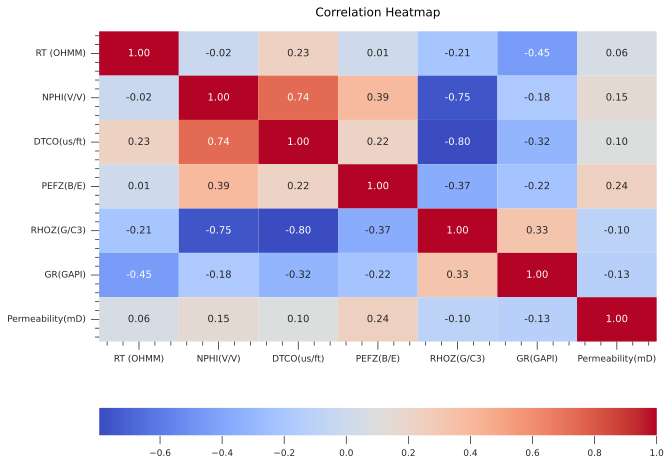

In [106]:
combined_df = pd.concat([df_944_PM, df_1215_PM, df_1116_PM, df_9_ITP_PM]).sort_values(by='DEPTH')
pd.reset_option('display.max_rows')
combined_df.reset_index(drop=True, inplace=True)
###########
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'combined_df' is your DataFrame containing petrophysical logs and permeability

# Filter out rows with 'k' values less than or equal to zero
combined_df = combined_df[combined_df['k'] > 0]

# Select the columns of interest
columns_of_interest = ["AT90", "NPHI", "DTCO", "PEFZ", "RHOZ", "GR", "k"]
combined_df = combined_df[columns_of_interest]

# Rename the columns with custom display names
combined_df = combined_df.rename(columns={
    "AT90": "RT (OHMM)",
    "NPHI": "NPHI(V/V)",
    "DTCO": "DTCO(us/ft)",
    "PEFZ": "PEFZ(B/E)",
    "RHOZ": "RHOZ(G/C3)",
    "GR": "GR(GAPI)",
    "k": "Permeability(mD)"
})

# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Create a heatmap with horizontal property names on the vertical axis
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={"orientation": "horizontal"})

# Rotate the y-axis labels to be horizontal
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title("Correlation Heatmap")
plt.show()


In [146]:
combined_df = pd.concat([df_944_PM, df_1215_PM, df_1116_PM, df_9_ITP_PM]).sort_values(by='DEPTH')
pd.reset_option('display.max_rows')
combined_df.reset_index(drop=True, inplace=True)

# ==========================================================

# Tuckey Method:

In [147]:
import pandas as pd
import numpy as np

def tukey_fences(data_series, k=3):
    # Calculate the first quartile (Q1) and the third quartile (Q3)
    q1 = data_series.quantile(0.25)
    q3 = data_series.quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Calculate the lower and upper fences
    lower_fence = q1 - k * iqr
    upper_fence = q3 + k * iqr

    return lower_fence, upper_fence

def handle_outliers(data_series, lower_fence, upper_fence):
    # Replace values below the lower fence with the lower fence
    data_series[data_series < lower_fence] = lower_fence

    # Replace values above the upper fence with the upper fence
    data_series[data_series > upper_fence] = upper_fence

    return data_series

#====
# Set the Tukey's k value (you can adjust this based on your data)
k_value = 1.5

# Clean the data for a specific column (e.g., 'your_column_name')
column_name = 'k'

# Calculate Tukey fences for the specified column
lower_fence, upper_fence = tukey_fences(combined_df[column_name], k_value)

# Handle outliers in the specified column
combined_df[column_name] = handle_outliers(combined_df[column_name], lower_fence, upper_fence)

# Print the cleaned DataFrame
combined_df

DEPTH       k   phi         GR       AT90      RHOZ      NPHI  \
0    5230.899893   50.10  16.4  18.364668  22.001585  2.112285  0.277651   
1    5231.099893  117.00  13.5  17.943176  16.073359  2.130714  0.297487   
2    5231.199893  185.00  18.7  18.042002  11.997000  2.124417  0.312481   
3    5231.599893    6.43  12.3  20.989471   8.388942  2.203261  0.309711   
4    5231.999893    5.66  12.1  21.451315  20.509071  2.273505  0.276384   
..           ...     ...   ...        ...        ...       ...       ...   
511  5794.400400   22.50  18.1  19.129719   6.142383  2.559285  0.109517   
512  5794.857400   15.40  18.5  19.666580   3.009704  2.474878  0.141756   
513  5795.162600   19.80  19.1  20.780230   3.046565  2.463385  0.139730   
514  5795.467300   10.30  17.6  23.912481   3.046565  2.450901  0.161174   
515  5795.619600    3.79  13.0  22.685303   3.046565  2.448614  0.170256   

          DTCO      PEFZ     NMRFF    NMREFF    NMRTOT  
0    68.337450  8.430419  0.146941  0.206191  0.279142  
1    67.663246  8.383753  0.137963  0.210700  0.263316  
2    67.298560  8.239479  0.131576  0.215271  0.257083  
3    65.314200  7.864687  0.097340  0.224917  0.237006  
4    67.033295  7.956197  0.079618  0.182904  0.189701  
..         ...       ...       ...       ...       ...  
511  61.002037  6.030134  0.000894  0.001053  0.001053  
512  63.389927  5.481481  0.001111  0.001326  0.001327  
513  64.736520  5.335359  0.001222  0.001480  0.001480  
514  66.790855  5.273507  0.001352  0.001640  0.001685  
515  66.684540  5.314323  0.001450  0.001748  0.001813  

[516 rows x 12 columns]

# ================================================

<span style='color:gray'> <span style="font-size:30px;">**Build the model**</span> </span>

# Random Forest

Normalization:

In [185]:
from sklearn.model_selection import train_test_split

# Assuming 'combined_df' is your DataFrame

# Filter out rows with 'k' values less than or equal to zero
combined_df = combined_df[combined_df['k'] > 0]

#X = combined_df[["AT90", "NPHI", "DTCO", "PEFZ", "RHOZ", "GR"]]
X = combined_df[["AT90", "NPHI", "DTCO", "PEFZ"]]
y = combined_df[["k"]]

# Flatten y_train and y_test to 1-dimensional arrays to avoid DataConversionWarning
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can reset the index
combined_df.reset_index(drop=True, inplace=True)

print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(489, 4) (489, 1) (391, 4) (98, 4) (391, 1) (98, 1)


In [186]:
# Apply a log transformation to 'y'
y_train_transformed = np.log(y_train)
y_test_transformed = np.log(y_test)
#
y_train_transformed = np.ravel(y_train_transformed)
y_test_transformed = np.ravel(y_test_transformed)

In [187]:
rf_n_estimators = [100, 150, 200, 250, 300, 350, 400]
rf_max_depth = [5, 10, 15, 20, 25]
rf_criterion = ['squared_error']                         # "squared_error" is by default. It is optional

rf_grid = {'n_estimators': rf_n_estimators,
           'max_depth': rf_max_depth,
           'criterion': rf_criterion}

In [188]:
rf_model = RandomForestRegressor(random_state=42)        # Shuffle=True by default

rf_random = RandomizedSearchCV(rf_model, rf_grid, n_iter=20, cv=10, random_state=42)

#rf_random.fit(X_train_processed, y_train)
rf_random.fit(X_train, y_train_transformed)

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'criterion': ['squared_error'],
                                        'max_depth': [5, 10, 15, 20, 25],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400]},
                   random_state=42)

In [189]:
best_parameters = rf_random.best_params_
print(best_parameters)

{'n_estimators': 200, 'max_depth': 10, 'criterion': 'squared_error'}


In [190]:
highest_accuracy = rf_random.best_score_ 
highest_accuracy

0.146375877356212

In [191]:
highest_accuracy = round(highest_accuracy,4)
highest_accuracy = highest_accuracy*100
print('Coefficient of Determination for the Random Forest =', highest_accuracy)

Coefficient of Determination for the Random Forest = 14.64


In [192]:
rf_final_model = RandomForestRegressor(
    n_estimators=best_parameters['n_estimators'],
    max_depth=best_parameters['max_depth'],
    random_state=42,
    criterion=best_parameters['criterion']
)

In [195]:
rf_final_model.fit(X_train, y_train.values.ravel())  # Fit the RandomForestRegressor model with training data
y_pred_rf = rf_final_model.predict(X)   # Make predictions on the test data

# plot

<function matplotlib.pyplot.show(close=None, block=None)>

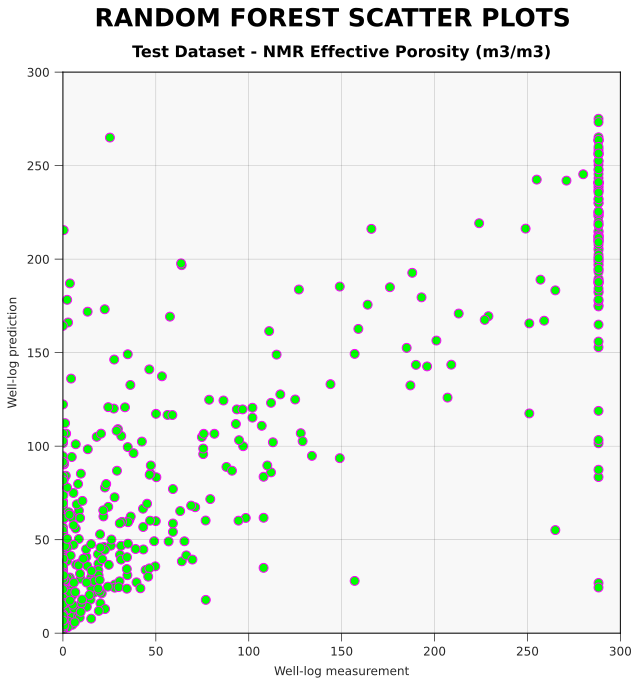

In [197]:
# Random Forest Scatter Plots 
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.suptitle("RANDOM FOREST SCATTER PLOTS", fontsize=25, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1) 

# First Scatter Plot
ax1.scatter(y,y_pred_rf, s=80, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well-log measurement', fontsize=12) 
ax1.set_ylabel('Well-log prediction', fontsize=12)
ax1.set_title('Test Dataset - NMR Effective Porosity (m3/m3)', fontsize=16, fontweight='bold')
#ax1.semilogy()                                                           # x in a log scale
#ax1.semilogx()                                                           # x in a log scale
ax1.set_xlim(0,300)
ax1.set_ylim(0,300)
#ax1.set_xticks(np.arange(0, 0.25, 0.025))
#ax1.set_yticks(np.arange(0, 0.25, 0.025))

# Add a black border to each subplot
for ax in [ax1]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1]:
    ax.grid(color='black',lw=0.5)

plt.show

# ======================================================

# Gradient Boosting

In [176]:
from sklearn.model_selection import train_test_split

# Assuming 'combined_df' is your DataFrame

# Filter out rows with 'k' values less than or equal to zero
combined_df = combined_df[combined_df['k'] > 0]

X = combined_df[["AT90", "NPHI", "DTCO", "PEFZ", "RHOZ", "GR"]]
#X = combined_df[["AT90", "NPHI", "DTCO", "PEFZ"]]
y = combined_df[["k"]]

# Flatten y_train and y_test to 1-dimensional arrays to avoid DataConversionWarning
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can reset the index
combined_df.reset_index(drop=True, inplace=True)

print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(489, 6) (489, 1) (391, 6) (98, 6) (391, 1) (98, 1)


Log Transformation

In [177]:
# Apply a log transformation to 'y'
y_train_transformed = np.log(y_train)
y_test_transformed = np.log(y_test)
#
y_train_transformed = np.ravel(y_train_transformed)
y_test_transformed = np.ravel(y_test_transformed)

In [178]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the hyperparameter grid
gb_n_estimators = [100, 150, 200, 250, 300, 350, 400]
gb_max_depth = [5, 10, 15, 20, 25]
gb_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
gb_criterion = ['friedman_mse', 'squared_error']  # Valid options

gb_grid = {
    'n_estimators': gb_n_estimators,
    'max_depth': gb_max_depth,
    'learning_rate': gb_rate,
    'criterion': gb_criterion
}

# Create the base GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Create the random search Gradient Boosting
gb_random = RandomizedSearchCV(gb_model, gb_grid, n_iter=20, cv=10, random_state=42)

# Fit the model
#gb_random.fit(X_train, y_train_transformed)  # Assuming you have defined X_train and y_train
gb_random.fit(X_train, y_train_transformed)  # Assuming you have defined X_train and y_train

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6],
                                        'max_depth': [5, 10, 15, 20, 25],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400]},
                   random_state=42)

In [179]:
gb_random.cv_results_

{'mean_fit_time': array([0.3183573 , 0.14768271, 0.09194908, 0.13001499, 0.09392238,
        0.2253432 , 0.15636308, 0.13491161, 0.31233618, 0.18144631,
        0.09089732, 0.14063694, 0.11697834, 0.17915647, 0.18762105,
        0.13244996, 0.28333912, 0.18222225, 0.05683413, 0.16887236]),
 'std_fit_time': array([0.00845423, 0.00789828, 0.00161655, 0.00788094, 0.00153098,
        0.00103676, 0.00318572, 0.00327853, 0.00963931, 0.00231533,
        0.00080196, 0.00272772, 0.00630752, 0.00575231, 0.00439175,
        0.00318337, 0.00081497, 0.0034496 , 0.00299549, 0.00676601]),
 'mean_score_time': array([0.00155454, 0.00127499, 0.00109506, 0.00113089, 0.00107899,
        0.00133071, 0.00132101, 0.00134044, 0.00182202, 0.00122397,
        0.00106668, 0.00131259, 0.00109246, 0.00137403, 0.00129492,
        0.00113578, 0.00161977, 0.00141592, 0.0010361 , 0.00161428]),
 'std_score_time': array([1.25240479e-04, 1.00008455e-04, 5.22056120e-05, 6.70564323e-05,
        7.94852072e-05, 4.79601003e-

In [180]:
best_parameters = gb_random.best_params_
print(best_parameters)  

{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.3, 'criterion': 'friedman_mse'}


In [181]:
highest_accuracy = gb_random.best_score_
highest_accuracy = round(highest_accuracy,3)
highest_accuracy = highest_accuracy*100
print('Coefficient of Determination for the Gradient Boosting =', highest_accuracy)

Coefficient of Determination for the Gradient Boosting = 12.7


In [182]:
# Access the best parameters from the RandomizedSearchCV results
best_parameters = gb_random.best_params_

# Create the final GradientBoostingRegressor model
gb_final_model = GradientBoostingRegressor(n_estimators=best_parameters['n_estimators'],
                                           max_depth=best_parameters['max_depth'],
                                           learning_rate=best_parameters['learning_rate'],
                                           random_state=42,
                                           criterion=best_parameters['criterion'])
gb_final_model.fit(X_train, y_train.values.ravel())  # Apply .values.ravel() here

GradientBoostingRegressor(learning_rate=0.3, max_depth=5, random_state=42)

In [183]:
# Train the tuned Gradient Boosting 
y_pred_gb = gb_final_model.predict(X)   # Make predictions on the test data

<function matplotlib.pyplot.show(close=None, block=None)>

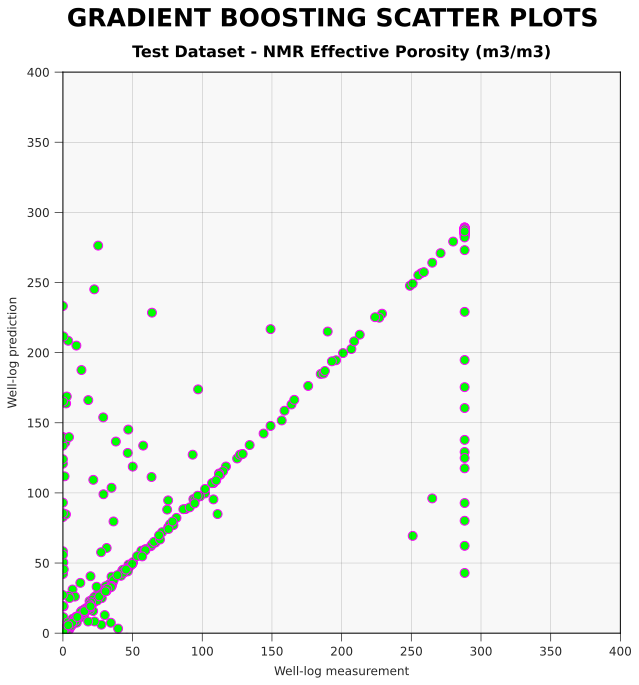

In [184]:
# Random Forest Scatter Plots 
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.suptitle("GRADIENT BOOSTING SCATTER PLOTS", fontsize=25, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1) 

# First Scatter Plot
ax1.scatter(y,y_pred_gb, s=80, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well-log measurement', fontsize=12) 
ax1.set_ylabel('Well-log prediction', fontsize=12)
ax1.set_title('Test Dataset - NMR Effective Porosity (m3/m3)', fontsize=16, fontweight='bold')
#ax1.semilogy()                                                           # x in a log scale
#ax1.semilogx()                                                           # x in a log scale
ax1.set_xlim(0,400)
ax1.set_ylim(0,400)
#ax1.set_xticks(np.arange(0, 0.25, 0.025))
#ax1.set_yticks(np.arange(0, 0.25, 0.025))

# Add a black border to each subplot
for ax in [ax1]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1]:
    ax.grid(color='black',lw=0.5)

plt.show

# ========

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'combined_df' is your DataFrame

# Filter out rows with 'k' values less than or equal to zero
combined_df = combined_df[combined_df['k'] > 0]

X = combined_df[["AT90", "NPHI", "DTCO", "PEFZ", "RHOZ", "GR"]]
#X = combined_df[["AT90", "NPHI", "DTCO", "PEFZ"]]
y = combined_df[["k"]]

# Flatten y_train and y_test to 1-dimensional arrays to avoid DataConversionWarning
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can reset the index
combined_df.reset_index(drop=True, inplace=True)

print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# Apply a log transformation to 'y'
y_train_transformed = np.log(y_train)
y_test_transformed = np.log(y_test)
#
y_train_transformed = np.ravel(y_train_transformed)
y_test_transformed = np.ravel(y_test_transformed)

In [277]:

# Define the hyperparameter grid
gb_n_estimators = [100, 150, 200, 250, 300, 350, 400]
gb_max_depth = [5, 10, 15, 20, 25]
gb_rate = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
gb_criterion = ['friedman_mse', 'squared_error']  # Valid options

gb_grid = {
    'n_estimators': gb_n_estimators,
    'max_depth': gb_max_depth,
    'learning_rate': gb_rate,
    'criterion': gb_criterion
}

# Create the base GradientBoostingRegressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Create the random search Gradient Boosting
gb_random = RandomizedSearchCV(gb_model, gb_grid, n_iter=20, cv=10, random_state=42)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
# Fit the model
#gb_random.fit(X_train, y_train_transformed)
gb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=20,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6],
                                        'max_depth': [5, 10, 15, 20, 25],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 350, 400]},
                   random_state=42)

In [278]:
from sklearn.feature_selection import SelectFromModel

# Access feature importance scores from the model used for feature selection
feature_importance = gb_model_for_feature_selection.feature_importances_

# Calculate the correlation between each feature and the target variable 'k' (permeability)
correlation_scores = X_train.corrwith(y)

# Sort the features by their correlation scores in descending order
selected_feature_names = correlation_scores.abs().sort_values(ascending=False).index

# Select the top N features (you can adjust N based on your preference)
N = 3  # For example, select the top 3 features
selected_feature_names = selected_feature_names[:N]

# Use the selected features for training and testing
X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['AT90', 'DTCO', 'GR'], dtype='object')


In [281]:
gb_model.fit(X_train_selected, y_train)

# Make predictions on the test dataset using the trained model
y_pred_selected = gb_model.predict(X_test_selected)

# Calculate the mean squared error (MSE) to evaluate the model's performance
mse = mean_squared_error(y_test_transformed, y_pred_selected)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 9663.84151749563


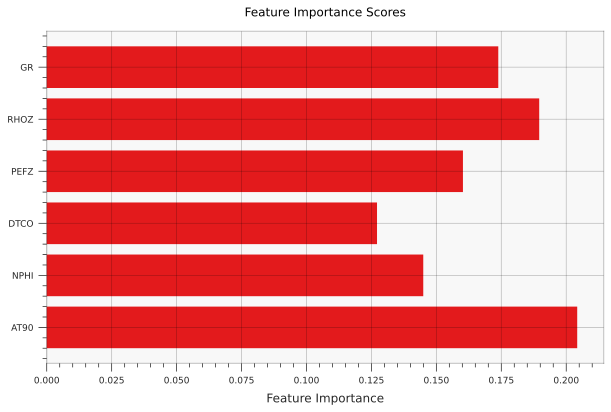

In [282]:
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt

# Fit the model with the original features
gb_model.fit(X_train, y_train_transformed)

# Access feature importance scores
feature_importance = gb_model.feature_importances_

# Visualize feature importance scores
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align='center')
plt.yticks(range(len(feature_importance)), X_train.columns)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Scores')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

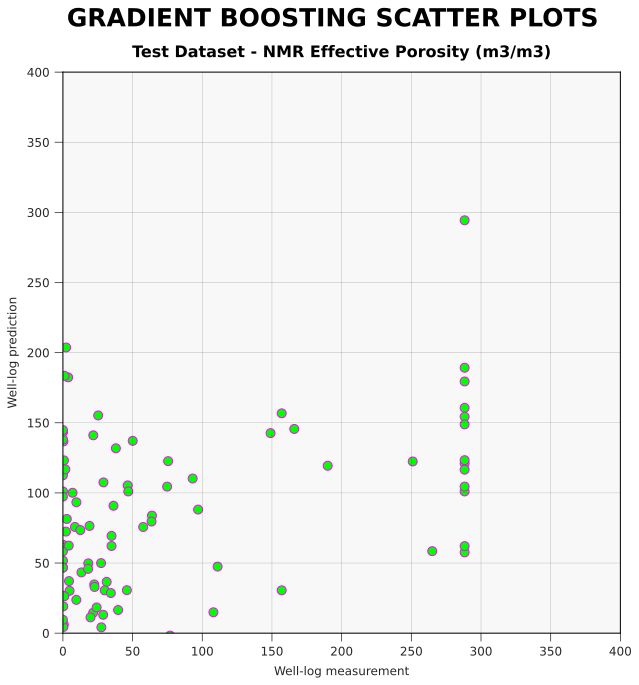

In [283]:
# Random Forest Scatter Plots 
fig, ax = plt.subplots(1,1, figsize=(10,10))
fig.suptitle("GRADIENT BOOSTING SCATTER PLOTS", fontsize=25, fontweight='bold')
fig.subplots_adjust(top=0.89,hspace=0.4)

#Set up the subplots grid
ax1 = plt.subplot2grid((1,1),(0,0),rowspan=1,colspan=1) 

# First Scatter Plot
ax1.scatter(y_test,y_pred_selected, s=80, c='lime', edgecolors='magenta')
ax1.set_xlabel('Well-log measurement', fontsize=12) 
ax1.set_ylabel('Well-log prediction', fontsize=12)
ax1.set_title('Test Dataset - NMR Effective Porosity (m3/m3)', fontsize=16, fontweight='bold')
#ax1.semilogy()                                                           # x in a log scale
#ax1.semilogx()                                                           # x in a log scale
ax1.set_xlim(0,400)
ax1.set_ylim(0,400)
#ax1.set_xticks(np.arange(0, 0.25, 0.025))
#ax1.set_yticks(np.arange(0, 0.25, 0.025))

# Add a black border to each subplot
for ax in [ax1]:
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')
    
# Set font size of the tick labels
for ax in [ax1]:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
# Set grid 
for ax in [ax1]:
    ax.grid(color='black',lw=0.5)

plt.show

# ========

# =================================================

# NSGA-II

In [70]:

# Concatenate the DataFrames along columns (axis=1)
combined_df = pd.concat([df_944_PM, df_1215_PM, df_1116_PM, df_9_ITP_PM]).sort_values(by='DEPTH')

#pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

# Reset the index
combined_df.reset_index(drop=True, inplace=True)
combined_df

DEPTH       k   phi         GR       AT90      RHOZ      NPHI  \
0    5230.899893   50.10  16.4  18.364668  22.001585  2.112285  0.277651   
1    5231.099893  117.00  13.5  17.943176  16.073359  2.130714  0.297487   
2    5231.199893  185.00  18.7  18.042002  11.997000  2.124417  0.312481   
3    5231.599893    6.43  12.3  20.989471   8.388942  2.203261  0.309711   
4    5231.999893    5.66  12.1  21.451315  20.509071  2.273505  0.276384   
..           ...     ...   ...        ...        ...       ...       ...   
511  5794.400400   22.50  18.1  19.129719   6.142383  2.559285  0.109517   
512  5794.857400   15.40  18.5  19.666580   3.009704  2.474878  0.141756   
513  5795.162600   19.80  19.1  20.780230   3.046565  2.463385  0.139730   
514  5795.467300   10.30  17.6  23.912481   3.046565  2.450901  0.161174   
515  5795.619600    3.79  13.0  22.685303   3.046565  2.448614  0.170256   

          DTCO      PEFZ     NMRFF    NMREFF    NMRTOT  
0    68.337450  8.430419  0.146941  0.206191  0.279142  
1    67.663246  8.383753  0.137963  0.210700  0.263316  
2    67.298560  8.239479  0.131576  0.215271  0.257083  
3    65.314200  7.864687  0.097340  0.224917  0.237006  
4    67.033295  7.956197  0.079618  0.182904  0.189701  
..         ...       ...       ...       ...       ...  
511  61.002037  6.030134  0.000894  0.001053  0.001053  
512  63.389927  5.481481  0.001111  0.001326  0.001327  
513  64.736520  5.335359  0.001222  0.001480  0.001480  
514  66.790855  5.273507  0.001352  0.001640  0.001685  
515  66.684540  5.314323  0.001450  0.001748  0.001813  

[516 rows x 12 columns]

In [71]:
pip install deap

Note: you may need to restart the kernel to use updated packages.


In [79]:
import random
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Define your objectives and their weights
creator.create("FitnessMulti", base.Fitness, weights=(1.0, -1.0))  # Maximize R-squared, minimize complexity
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Define your hyperparameter search space for Gradient Boosting

gradient_boosting_hyperparameter_space = {
    "n_estimators": [100, 150, 200, 250, 300],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.1, 0.2],  # Corrected learning_rate values as floats
    "criterion": ['friedman_mse', 'squared_error']
    # Add more Gradient Boosting hyperparameters here
}

def calculate_complexity(model):
    return len(model.estimators_)


def evaluate_individual(individual):
    # Extract hyperparameters from the individual
    hyperparameters = {
        "n_estimators": individual[0],
        "max_depth": individual[1],
        "learning_rate": individual[2],
        "criterion": individual[3]
    }

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the GradientBoostingRegressor model
    model = GradientBoostingRegressor(random_state=42, **hyperparameters)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate the R-squared score
    r2 = r2_score(y_test, y_pred)

    # Calculate complexity (you may need to define a measure for complexity)
    complexity = calculate_complexity(model)

    # Return two fitness values, maximizing R-squared and minimizing complexity
    return (r2, complexity)

# Function to mutate an individual
# Function to mutate an individual
def mutate_individual(ind):
    ind = toolbox.clone(ind)
    ind["learning_rate"] += random.gauss(0, 0.1)  # Apply mutation to learning_rate
    ind["learning_rate"] = max(0.01, min(1.0, ind["learning_rate"]))  # Ensure it stays within a valid range
    del ind.fitness.values
    return ind,


toolbox = base.Toolbox()
toolbox.register("attr_int", random.choice, gradient_boosting_hyperparameter_space["n_estimators"])
toolbox.register("attr_int", random.choice, gradient_boosting_hyperparameter_space["max_depth"])
toolbox.register("attr_float", random.choice, gradient_boosting_hyperparameter_space["learning_rate"])
toolbox.register("choice", random.choice, gradient_boosting_hyperparameter_space["criterion"])
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_int, toolbox.attr_int, toolbox.attr_float, toolbox.choice), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.2, indpb=0.2)
toolbox.register("select", tools.selNSGA2)


if __name__ == "__main__":
    # Create an initial population
    population = toolbox.population(n=50)

    # Define the number of generations
    num_generations = 10

    # Run the NSGA-II algorithm
    algorithms.eaMuPlusLambda(population, toolbox, mu=50, lambda_=30, cxpb=0.7, mutpb=0.3, ngen=num_generations, stats=None, halloffame=None)

    # Extract the Pareto front solutions
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]

    # Select the best hyperparameters from the Pareto front (based on your trade-off criteria)
    best_hyperparameters = None
    best_r2 = -float('inf')  # Initialize with negative infinity
    for ind in pareto_front:
        r2 = ind.fitness.values[0]
        if r2 > best_r2:
            best_r2 = r2
            best_hyperparameters = ind

    # Train the final GradientBoostingRegressor model using the selected hyperparameters
    final_hyperparameters = {
        "n_estimators": best_hyperparameters[0],
        "max_depth": best_hyperparameters[1],
        "learning_rate": best_hyperparameters[2],
        "criterion": best_hyperparameters[3]
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    final_model = GradientBoostingRegressor(random_state=42, **final_hyperparameters)
    final_model.fit(X_train, y_train)

    # Use the final model for prediction on new well log data
    y_pred = final_model.predict(X)


/Users/amirhosseinakhondzadeh/opt/anaconda3/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/amirhosseinakhondzadeh/opt/anaconda3/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/amirhosseinakhondzadeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/amirhosseinakhondzadeh/opt/anaconda3/lib/python3.9/si

gen	nevals
0  	50    


/Users/amirhosseinakhondzadeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/amirhosseinakhondzadeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/amirhosseinakhondzadeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/amirhosseinakhondzadeh/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A colu

TypeError: can only concatenate str (not "float") to str

normalization

In [ ]:
"""import pandas as pd

# Example: Assuming you've already applied Tukey's method to your dataset, and you have a DataFrame named combined_df

# Define the columns you want to normalize (excluding the 'DEPTH' column)
columns_to_normalize = ['k', 'phi', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT']

# Calculate the minimum and maximum values for each column
min_values = combined_df[columns_to_normalize].min()
max_values = combined_df[columns_to_normalize].max()

# Apply the min-max scaling formula
normalized_data = 2 * (combined_df[columns_to_normalize] - min_values) / (max_values - min_values) - 1

# Combine the normalized data with the 'DEPTH' column
normalized_data['DEPTH'] = combined_df['DEPTH']

# Print the normalized DataFrame
print(normalized_data)
"""
#======
"""import pandas as pd
import numpy as np

# Example: Assuming you've already applied Tukey's method to your dataset, and you have a DataFrame named combined_df

# Define the columns you want to normalize using a log transformation (excluding the 'DEPTH' column)
columns_to_transform = ['k', 'phi', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT']

# Apply the log transformation to the selected columns
normalized_data = combined_df.copy()  # Create a copy of the original DataFrame

for column in columns_to_transform:
    normalized_data[column] = np.log1p(normalized_data[column])

# Print the DataFrame with log-transformed columns
print(normalized_data)
"""
#======
"""
import pandas as pd
import numpy as np
from scipy import stats

# Example: Assuming you've already applied Tukey's method to your dataset, and you have a DataFrame named combined_df

# Define the columns you want to normalize using the Yeo-Johnson transformation (excluding the 'DEPTH' column)
columns_to_transform = ['k', 'phi', 'GR', 'AT90', 'RHOZ', 'NPHI', 'DTCO', 'PEFZ', 'NMRFF', 'NMREFF', 'NMRTOT']

# Apply the Yeo-Johnson transformation to the selected columns
normalized_data = combined_df.copy()  # Create a copy of the original DataFrame

for column in columns_to_transform:
    # Apply the Yeo-Johnson transformation
    normalized_data[column], _ = stats.yeojohnson(normalized_data[column])

# Print the DataFrame with Yeo-Johnson-transformed columns
normalized_data
"""

In [ ]:
"""import skfuzzy as fuzz
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score


# Define a custom estimator

class FuzzyClusteringEstimator:
    def __init__(self, m=1.5, error=0.005, maxiter=1000):
        self.m = m
        self.error = error
        self.maxiter = maxiter

    def fit(self, X, y):

        # Convert the training data to a NumPy array.
        X = np.array(X)
        # Train the fuzzy clustering model.
        self.model = fuzz.cluster.cmeans(X, c=2, m=self.m, error=self.error, maxiter=self.maxiter)

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values  # Convert DataFrame to NumPy array

        cluster_centers = self.model[0]  # Access cluster centers
        num_clusters = cluster_centers.shape[0]
        num_samples = X.shape[0]
        u = np.zeros((num_clusters, num_samples))

        for i in range(num_samples):
            for j in range(num_clusters):
                total_distance = np.sum((X[i] - cluster_centers[j]) ** 2)
                denominator = sum([((total_distance / np.sum((X[i] - cluster_centers[k].reshape(-1, 1)) ** 2)) ** (1 / (self.m - 1))) for k in range(num_clusters)])
                u[j, i] = 1 / denominator

        return np.argmax(u, axis=0)
    
    def score(self, X, y=None):
        # Use silhouette score as a performance metric
        cluster_centers, membership = self.model
        membership = fuzz.cluster.cmeans_predict(X, cluster_centers, m=self.m, error=self.error)
        memberships = np.argmax(membership, axis=0)
        silhouette_avg = silhouette_score(X, memberships)
        return silhouette_avg

    def get_params(self, deep=True):
        return {
            'm': self.m,
            'error': self.error,
            'maxiter': self.maxiter
        }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

#===================

# Define the hyperparameters to tune
param_grid = {
    'm': [1.1, 1.5, 2.0],  # Fuzziness coefficient
    'error': [0.001, 0.005, 0.01],  # Convergence error
    'maxiter': [500, 1000, 1500]  # Maximum number of iterations
}

# Create a FuzzyClusteringEstimator object with the custom estimator and hyperparameters
fuzzy_estimator = FuzzyClusteringEstimator()
grid_search = GridSearchCV(fuzzy_estimator,
                           param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=-1,
                           scoring='neg_mean_squared_error')
"""

In [ ]:
#grid_search.fit(X_train, y_train)

In [ ]:
"""
# Get the best estimator and its hyperparameters
best_fuzzy_estimator = grid_search.best_estimator_
best_hyperparams = grid_search.best_params_

# Predict using the best model
#k_pred = best_fuzzy_estimator.predict(X_test)

# You may want to use the mean of the memberships or other aggregation methods to get a single value for each prediction


best_fuzzy_estimator


best_hyperparams
"""

<span style='color:blue'> <span style="font-size:15px;"> **Print the best hyperparameters**:</span> </span>

Combination that gives **the highest accuracy (coefficient of determination) during the cross-validation**

## Finalized GB Model

Create the tuned Gradient Boosting 

<span style='color:gray'> <span style="font-size:20px;">**Evaluation of the Tuned Models and Visualization of Results**</span> </span>

We consider the Test Dataset or, also called, the Hold-Out Dataset (20% of the Original Dataset) and we perform the prediction on this Dataset which is the "unseen" Dataset.


<span style='color:gray'> <span style="font-size:30px;">**PLOTS**</span> </span>

Tucky Method: